# Train additional NER models for ACL 2023 paper

In this notebook, we will evaluate a number of selected models for the ACL 2023 paper.

## Preliminaries

We will begin with a bit of boilerplate, logging information and setting up the computational environment.

In [1]:
! hostname

docker.apollo.fi.muni.cz


In [2]:
! python -V

Python 3.8.12


Install the current version of the package and its dependencies.

In [3]:
%%capture
! pip install .

Make sure numpy does not parallelize.

In [4]:
import os

In [5]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

Pick the GPU that we will use.

In [6]:
! nvidia-smi -L

/bin/sh: 1: nvidia-smi: not found


In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Set up logging to display informational messages.

In [8]:
import logging
import sys

In [9]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format='%(message)s')

## Train models

We will train the NER models using the `scripts/05_train_additional_ner_models_for_paper.sh` script from [Git commit `597fd669`][1] (2023-01-17).

 [1]: https://gitlab.fi.muni.cz/nlp/ahisto-modules/named-entity-search/-/commit/597fd669bc9e84b3d7ac3cb465947f01192cd094

In [10]:
from ahisto_named_entity_search.recognition import NerModel

generated new fontManager


comet_ml is installed but `COMET_API_KEY` is not set.


In [11]:
large_model = NerModel.load('model_ner_manatee_non-crossing_only-relevant_fair-sequential_007')

In [12]:
baseline_model = NerModel('xlm-roberta-large-finetuned-conll03-german',
                          labels=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'])

In [13]:
small_models = [
    NerModel.load('model_ner_books-medium_books-large_weighted_008'),
#   NerModel.load('model_ner_books-medium_books-medium+regests-tiny_weighted_008'),
    NerModel.load('model_ner_books-medium_books-medium_weighted_008'),
#   NerModel.load('model_ner_books-medium_books-small+regests-tiny_weighted_008'),
    NerModel.load('model_ner_books-medium_books-small_unweighted_008'),
    NerModel.load('model_ner_books-medium_books-small_weighted_008'),
]

In [14]:
models = [
    large_model,
    baseline_model,
] + small_models

## Evaluate models

For all models, we will compute the per-token $F_\beta$-score ($\beta = 0.25$).
For our large model, we will also compute the per-entity Precision and Recall and a confusion matrix.

In [15]:
from ahisto_named_entity_search.search import TaggedSentence

### Datasets from search results

In [16]:
testing_tagged_sentences = list(TaggedSentence.load('dataset_ner_manatee_non-crossing_only-relevant_testing_401-500_tagged'))

In [17]:
for model in models:
    confusion_matrix = TaggedSentence.confusion_matrix(model, testing_tagged_sentences, use_bio_tags=False)
    print(f'- {model}: {100.0 * confusion_matrix.f_score:.2f}%')

- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_manatee_non-crossing_only-relevant_fair-sequential_007/BIOTokenWeightedClassification: 93.28%
- xlm-roberta-large-finetuned-conll03-german: 79.12%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-large_weighted_008/BIOTokenWeightedClassification: 88.99%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-medium_weighted_008/BIOTokenWeightedClassification: 93.10%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-small_unweighted_008/BIOTokenWeightedClassification: 84.45%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-small_weighted_008/BIOTokenWeightedClassification: 88.17%


In [18]:
TaggedSentence.evaluate(large_model, testing_tagged_sentences)

The results achieved Precision of 72.81--93.98%, Recall of 58.14--81.77%.

In [19]:
czech_sentence_ids = {2, 4, 12, 16, 18, 20, 21, 23, 27, 33, 36, 38, 39, 41, 46, 50, 52, 56, 82, 91, 94, 95, 96}
latin_sentence_ids = {1, 5, 6, 8, 9, 13, 14, 17, 19, 22, 25, 26, 30, 32, 34, 40, 42, 43, 44, 45, 47, 48, 49,
                      54, 55, 59, 60, 64, 65, 66, 68, 70, 73, 74, 75, 76, 79, 81, 89, 92, 93, 97, 99, 100}
german_sentence_ids = {3, 7, 10, 11, 15, 24, 28, 29, 31, 35, 37, 51, 53, 57, 58, 61, 62, 63, 67, 69, 71, 72,
                       77, 78, 80, 83, 84, 85, 86, 87, 88, 90, 98}

In [20]:
assert len(czech_sentence_ids | latin_sentence_ids | german_sentence_ids) == \
       len(czech_sentence_ids) + len(latin_sentence_ids) + len(german_sentence_ids)
assert len(czech_sentence_ids | latin_sentence_ids | german_sentence_ids) == \
       len(testing_tagged_sentences)

In [21]:
testing_tagged_sentences_czech = [sentence for sentence_id, sentence in enumerate(testing_tagged_sentences) if (sentence_id + 1) in czech_sentence_ids]
testing_tagged_sentences_latin = [sentence for sentence_id, sentence in enumerate(testing_tagged_sentences) if (sentence_id + 1) in latin_sentence_ids]
testing_tagged_sentences_german = [sentence for sentence_id, sentence in enumerate(testing_tagged_sentences) if (sentence_id + 1) in german_sentence_ids]

In [22]:
print(f'- Czech: {TaggedSentence.evaluate(large_model, testing_tagged_sentences_czech)}')
print(f'- Latin: {TaggedSentence.evaluate(large_model, testing_tagged_sentences_latin)}')
print(f'- German: {TaggedSentence.evaluate(large_model, testing_tagged_sentences_german)}')

- Czech: The results achieved Precision of 77.42--95.63%, Recall of 59.70--86.93%.
- Latin: The results achieved Precision of 70.21--96.48%, Recall of 53.66--77.95%.
- German: The results achieved Precision of 70.80--87.07%, Recall of 64.52--81.30%.


In [23]:
confusion_matrix = TaggedSentence.confusion_matrix(large_model, testing_tagged_sentences,
                                                   displayed_labels=['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC'])

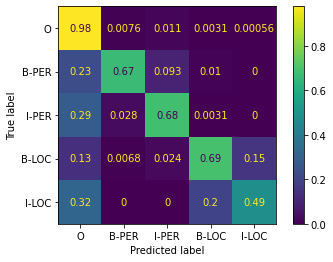

In [24]:
confusion_matrix.display().figure_.savefig('confusion-matrix-books.pdf', dpi=300, bbox_inches='tight')

### Datasets from regests

In [25]:
testing_tagged_sentences = list(TaggedSentence.load('dataset_ner_regests_testing_001-400'))

In [26]:
for model in models:
    confusion_matrix = TaggedSentence.confusion_matrix(model, testing_tagged_sentences, use_bio_tags=False)
    print(f'- {model}: {100.0 * confusion_matrix.f_score:.2f}%')

- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_manatee_non-crossing_only-relevant_fair-sequential_007/BIOTokenWeightedClassification: 91.41%
- xlm-roberta-large-finetuned-conll03-german: 80.34%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-large_weighted_008/BIOTokenWeightedClassification: 87.18%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-medium_weighted_008/BIOTokenWeightedClassification: 90.49%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-small_unweighted_008/BIOTokenWeightedClassification: 86.39%
- /nlp/projekty/ahisto/public_html/named-entity-search/results/model_ner_books-medium_books-small_weighted_008/BIOTokenWeightedClassification: 88.91%
